# Inverse Probability of Treatment Weights
In the previous tutorial, we used the g-formula (or g-computation algorithm) to estimate the causal effect of ART on the 45-week all cause mortality. That approach required the correct specification of the $\widehat{E}[Y|A,L]$ regression model. That means we had to have all the interaction terms between treatment ($A$) and all confounders ($L$) correctly specified. In this tutorial we will use inverse probability of treatment weights (IPTW). This approach no longer requires us to estimate all the $A$-with-$L$ interaction correctly (in fact, we no longer need to model any of those). We only need to modeling $\widehat{\Pr}(A=a|L)$ instead. 

The unstabilized weights take the following form
$$\widehat{W_i} = \frac{1}{\widehat{\Pr}(A=a|L)}$$
where if an individual was treated ($A=1$), their weight is $\widehat{W_i} = \frac{1}{\widehat{\Pr}(A=1|L)}$ and if untreated ($A=0$), $\widehat{W_i} = \frac{1}{\widehat{\Pr}(A=0|L)}$

To stabilize weights, we modify the numerator. This modification often has little consequence for time-fixed scenarios (infact, unstabilized and stabilized weights should give the same answer) but only stabilized weights are recommended for time-varying weights. Stabilized weights take the following form
$$\widehat{SW_i} = \frac{\widehat{\Pr}(A=a)}{\widehat{\Pr}(A=a|L)}$$

After estimating weights, we then estimate a marginal structural model. The marginal structural model takes the following form
$$\widehat{Y} = \beta_0 + \beta_1 A$$
and the average treatment effect of $A$ on $Y$ is $\beta_1$. 

## Why it works
Before continuing, a brief aside on why this approach works. For the g-formula, we saw how we directly estimated potential outcomes and filled them in. IPTW is not as readily transparent (at least not to me). What this approach does is construct a pseudo-population. In our new pseudo-population the average causal effect of $A$ on $Y$ is the same as the average causal effect in our observed population. However, in our pseudo-population our set of confounders, $L$, are no longer related to $A$. 

Specifically, our probabilities of treatment weight individuals to their treatment. So, if individuals with $L=1$ are less likely to be treated with $A$, those who with $L=1$ and $A=1$ are up-weighted in our pseudo-population. A similar process applies for down-weighting. For further discussion and intuition, I recommend reading through the references listed below

## An example
To motivate our example, we will use a simulated data set included with *zEpid*. In the data set, we have a cohort of HIV-positive individuals. We are interested in the sample average treatment effect of antiretroviral therapy (ART) on all-cause mortality at 45-weeks. Based on substantive background knowledge, we believe that the treated and untreated population are exchangeable based gender, age, CD4 T-cell count, and detectable viral load. 

In [24]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from zepid import load_sample_data, spline

df = load_sample_data(False)
df[['age_rs1', 'age_rs2']] = spline(df, 'age0', n_knots=3, term=2, restricted=True)
df[['cd4_rs1', 'cd4_rs2']] = spline(df, 'cd40', n_knots=3, term=2, restricted=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 547 entries, 0 to 546
Data columns (total 13 columns):
id          547 non-null int64
male        547 non-null int64
age0        547 non-null int64
cd40        547 non-null int64
dvl0        547 non-null int64
art         547 non-null int64
dead        517 non-null float64
t           547 non-null float64
cd4_wk45    460 non-null float64
age_rs1     547 non-null float64
age_rs2     547 non-null float64
cd4_rs1     547 non-null float64
cd4_rs2     547 non-null float64
dtypes: float64(7), int64(6)
memory usage: 59.8 KB


With our data loaded, we are now ready to estimate the inverse probability of treatment weights. We can do this by using the `IPTW` class in *zEpid*. This class is initialized with our data set and the column name for the treatment.

### Unstabilized Weights
We will start with estimation with unstabilized weights. We will specify the optional argument `stabilized=False` to generate the unstabilized weights

In [25]:
from zepid.causal.ipw import IPTW

iptw = IPTW(df, treatment='art', stabilized=False)

With the specified `IPTW` class, we will now use the `regression_models()` function. In this model, we will specify $L$. Based on substantive background knowledge, we believe that the treated and untreated population are exchangeable based gender, age, CD4 T-cell count, and detectable viral load. Additionally, we will use spline terms for age and baseline CD4 T-cell count

In [26]:
iptw.regression_models('male + age0 + age_rs1 + age_rs2 + cd40 + cd4_rs1 + cd4_rs2 + dvl0')


----------------------------------------------------------------
MODEL: art ~ male + age0 + age_rs1 + age_rs2 + cd40 + cd4_rs1 + cd4_rs2 + dvl0
-----------------------------------------------------------------
                 Generalized Linear Model Regression Results                  
Dep. Variable:                    art   No. Observations:                  547
Model:                            GLM   Df Residuals:                      538
Model Family:                Binomial   Df Model:                            8
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -214.63
Date:                Thu, 04 Apr 2019   Deviance:                       429.26
Time:                        17:23:31   Pearson chi2:                     539.
No. Iterations:                     5   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]

After specifying and fitting our regression model, the weights can be calculated by calling the `fit()` function. This will calculate the corresponding weights. Afterwards, we can access the `Weights` attribute to return our vector of weights. We will add these to our data set in a new column labeled 'uw' for unstabilized weights

In [29]:
iptw.fit()
df['uw'] = iptw.Weight

### Diagnostics
Before going further, let's go through some diagnostics for our weights. All diagnostics can be ran after calling the `fit()` function. Current diagnostics include; distributions of predicted probabilities, Love plots (for confounder balance), and weight behavior

First, we will look at the predicted probability distributions. We will stratify by treatment and compare the probability of receiving treatment based on an individual's covariates. We expect these distributions to overlap with each other. If they do not, that is indicative of positivity issues. 

There are two options in *zEpid*; we can look at density plot or a box plot. Let's look at both

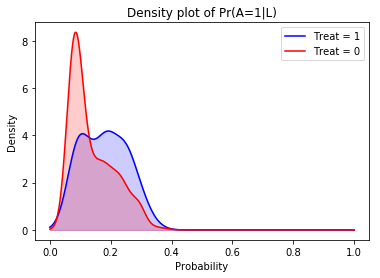

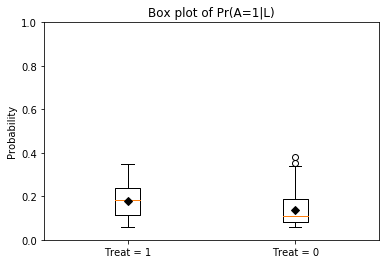

In [30]:
# Density plot
iptw.plot_kde()
plt.title('Density plot of Pr(A=1|L)')
plt.show()

# Box plot
iptw.plot_boxplot()
plt.title('Box plot of Pr(A=1|L)')
plt.ylim([0, 1])
plt.show()

Based on these plots, it doesn't look like we have any gross positivity violations. This would suggest our weights aren't doing anything weird and that everyone in the sample has some counterpart who was treated/treated. 

Next, we can look to see how well our covariates are balanced. We can do this by using a Love plot. A Love plot displays the absolute values of the standardized mean differences for all covariates. It will present the standardized mean differences for the unweighted and weighted data. Let's look at our example

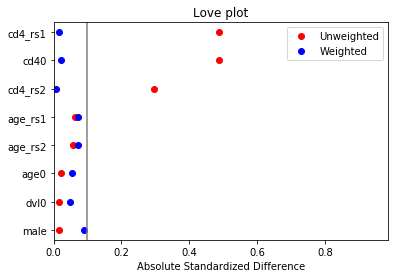

In [31]:
iptw.plot_love()
plt.title('Love plot')
plt.show()

Based on the above Love plot, we have pretty good balance of our confounders in the weighted population. As a general rule of thumb, all covariates should be below a standardized mean difference of 0.10. So, this suggests we are accounting for the measured confounders adequately. If there was still imbalance, we might consider adding interaction terms or different splines for continuous covariates.

Lastly, we will assess the behavior of the weights. We can do this with `positivity()`. Let's take a look

In [32]:
iptw.positivity()

          Inverse Probability of Treatment Weight Diagnostics
If the mean of the weights is far from either the min or max, this may
 indicate the model is incorrect or positivity is violated
Average weight should be
	1.0 for stabilized
	2.0 for unstabilized
Standard deviation can help in IPTW model selection
----------------------------------------------------------------------
Mean weight:            1.986
Standard Deviation:     2.366
Minimum weight:         1.06
Maximum weight:         16.919


From this, we get some summary statistics for our weights. As the above documentation suggests, the average weight fr unstabilized weights should be 2. Our mean weight is 1.986, which is fairly close. Additionally, the maximum and minimum weights are not too crazy (if maximum weight was 100+, there might be some concerns regarding positivity). 

I am happy with our weight specification. So, let's estimate our marginal structural model.

### Marginal Structural Model
*zEpid* does not naturally specify the marginal structural model. The reason being I am unable to allow for sufficient flexibility of this model (when doing assessment of effect measure modification). To estimate the parameters of the marginal structural model, we will use *statsmodels* GEE. There are two reasons for using GEE; *statsmodels* GLM does not allow weights, and confidence intervals. 

For the confidence intervals of the marginal structural model, we need to use robust standard errors (sandwich estimator of variance). For some intuition as to why, remember that we are up-weighting some individuals to count for more than one person. However, we are creating exact replicas of them. The replicas are correlated with each other and we need to account for that replication.

The confidence intervals can also be calculated using a non-parametric bootstrapping procedure. Confidence intervals from bootstrapping will likely be narrower than the GEE confidence intervals. I wont' demonstrate it, but you can easily adapt other code for bootstrapping and the code below.

Alright, let's estimate the marginal structural model

In [33]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.genmod.families import family,links

ind = sm.cov_struct.Independence()
f = sm.families.family.Binomial(sm.families.links.identity)
linrisk = smf.gee('dead ~ art', df['id'], df, cov_struct=ind, family=f, weights=df['uw']).fit()

print('RD = ', np.round(linrisk.params[1], 3))
print('95% CL:', np.round(linrisk.conf_int().iloc[1][0], 3), 
      np.round(linrisk.conf_int().iloc[1][1], 3))

RD =  -0.082
95% CL: -0.156 -0.007


c:\users\zivic\appdata\local\programs\python\python36\lib\site-packages\statsmodels\genmod\generalized_estimating_equations.py:472: DomainWarning: The identity link function does not respect the domain of the Binomial family.
  DomainWarning)


*statsmodels* will generate a warning about the specific link-family specification, but this is alright. This combination will estimate the risk difference. From these results we would conclude that the 45-week risk of death when everyone was treated with ART was 8.2% points lower (95% CL: -0.15.6, -0.7) than if no one had been treatd with ART.

These results are fairly close to the `TimeFixedGFormula` results. The results are not the same because we have model misspecification for (at least one of) our parametric regression models. If you are worried about model misspecification (you should be), I would recommend fitting both. If the results are fairly similar, you can rest easy. If they are different (and even if they are not), then I would recommend using a doubly robust estimator (like `AIPTW`).

## Stabilized Weights
Below is code to generate the stabilized weights. The process is largely the same. I will also run `positivity()` to show the difference in the weight distribution

In [34]:
# Calculating stabilized weights
iptw = IPTW(df, treatment='art', stabilized=True)
iptw.regression_models('male + age0 + age_rs1 + age_rs2 + cd40 + cd4_rs1 + cd4_rs2 + dvl0', print_results=False)
iptw.fit()

# Positivity diagnostic
iptw.positivity()

          Inverse Probability of Treatment Weight Diagnostics
If the mean of the weights is far from either the min or max, this may
 indicate the model is incorrect or positivity is violated
Average weight should be
	1.0 for stabilized
	2.0 for unstabilized
Standard deviation can help in IPTW model selection
----------------------------------------------------------------------
Mean weight:            0.998
Standard Deviation:     0.203
Minimum weight:         0.416
Maximum weight:         2.444


In [37]:
df['sw'] = iptw.Weight

linrisk = smf.gee('dead ~ art', df['id'], df, cov_struct=ind, family=f, weights=df['sw']).fit()

print('RD = ', np.round(linrisk.params[1], 3))
print('95% CL:', np.round(linrisk.conf_int().iloc[1][0], 3), 
      np.round(linrisk.conf_int().iloc[1][1], 3))

RD =  -0.082
95% CL: -0.156 -0.007


which gives us the same estimate of the risk difference, but has a different distribution for the weights. You can also estimate the risk ratio by specifying `f = sm.families.family.Binomial(sm.families.links.log)`. 

## Continuous Outcomes
Estimating the average treatment effect for continuous outcomes is easy. We don't need to do anything with `IPTW`. Rather, we change the marginal structural model. To motivate this example, we will assess the causal effect of ART on CD4 T-cell count at 45 weeks (we will ignore the implications of competing risk for now)

Let's go through the example with stabilized weights

In [38]:
f = sm.families.family.Gaussian()
ate = smf.gee('cd4_wk45 ~ art', df['id'], df, cov_struct=ind, family=f, weights=df['sw']).fit()

print('ATE = ', np.round(ate.params[1], 1))
print('95% CL:', np.round(ate.conf_int().iloc[1][0], 1), 
      np.round(ate.conf_int().iloc[1][1], 1))

ATE =  209.904
95% CL: 101.187 318.62


Therefore, under the counterfactual where everyone had been treated with ART, the mean CD4 T-cell count of study participants would be 209.9 (95% CL: 101.2, 318.8) higher compared to the counterfactual where no one was treated. However, we have been making a strong assumption throughout (that is easy to miss). Do you know what it is?

## Missing Data
Both `dead` (n=517) and `cd4_wk45` (n=460) have missing data. While these may be referred to as censoring (and inverse probability of censoring weights to relax some assumptions), we will use `IPMW` to calculate these. For more details on how these weights are calculated, see the missing data guide

We will generate separate missing weights for `dead` and `cd4_wk45`. Additionally, we will assume outcome data is missing completely at random conditional on our confounders and ART.

In [42]:
from zepid.causal.ipw import IPMW

# Estimating IPMW for `dead`
ipmw = IPMW(df, missing_variable='dead', stabilized=True)
ipmw.regression_models(model_denominator='art + male + age0 + age_rs1 + age_rs2 + cd40 + cd4_rs1 + cd4_rs2 + dvl0',
                       model_numerator='art', print_results=False)
ipmw.fit()

df['mw_dead'] = ipmw.Weight

In [43]:
# Estimating IPMW for `dead`
ipmw = IPMW(df, missing_variable='cd4_wk45', stabilized=True)
ipmw.regression_models(model_denominator='art + male + age0 + age_rs1 + age_rs2 + cd40 + cd4_rs1 + cd4_rs2 + dvl0',
                       model_numerator='art', print_results=False)
ipmw.fit()

df['mw_cd4'] = ipmw.Weight

To get the final weights, we multiply the estimate IPMW by the IPTW. We then fit our marginal structural model with these new weights. Let's fit our models again

In [47]:
# Estimating Effect of ART on CD T-cell count at week 45 with IPTW and IPMW
df['msw_dead'] = df['sw'] * df['mw_dead']

f = sm.families.family.Binomial(sm.families.links.identity)
linrisk = smf.gee('dead ~ art', df['id'], df, cov_struct=ind, family=f, weights=df['msw_dead']).fit()

print('RD = ', np.round(linrisk.params[1], 3))
print('95% CL:', np.round(linrisk.conf_int().iloc[1][0], 3), 
      np.round(linrisk.conf_int().iloc[1][1], 3))

RD =  -0.081
95% CL: -0.156 -0.005


c:\users\zivic\appdata\local\programs\python\python36\lib\site-packages\statsmodels\genmod\generalized_estimating_equations.py:472: DomainWarning: The identity link function does not respect the domain of the Binomial family.
  DomainWarning)


In [44]:
# Estimating Effect of ART on CD T-cell count at week 45 with IPTW and IPMW
df['msw_cd4'] = df['sw'] * df['mw_cd4']

f = sm.families.family.Gaussian()
ate = smf.gee('cd4_wk45 ~ art', df['id'], df, cov_struct=ind, family=f, weights=df['msw_cd4']).fit()

print('ATE = ', np.round(ate.params[1], 1))
print('95% CL:', np.round(ate.conf_int().iloc[1][0], 1), 
      np.round(ate.conf_int().iloc[1][1], 1))

ATE =  205.1
95% CL: 96.9 313.3


Our results are fairly similar when adding IPMW. This approach has the advantage of making less restrictive assumptions than the previous model. 

# Conclusions
In this tutorial, I have went through the basics of inverse probability of treatment weights and using them to estimate marginal structural models. I demonstrated how to estimate a marginal structural model using *zEpid* to estimate the risk difference and average treatment effect. Lastly, I demonstrated how to make less restrictive assumptions regarding missing data with inverse probability of missing weights. In the next tutorial, we will go through a version of IPTW to estimate the average treatment effect in the (un)treated.

## References
Robins JM, Hernan MA, Brumback B. (2000). Marginal structural models and causal inference in epidemiology.

Hernán MÁ, Brumback B, Robins JM. (2000). Marginal structural models to estimate the causal effect of zidovudine on the survival of HIV-positive men. Epidemiology, 561-570.

Cole SR, Hernán MA. (2008). Constructing inverse probability weights for marginal structural models. American journal of epidemiology, 168(6), 656-664.

Austin PC, Stuart EA. (2015). Moving towards best practice when using inverse probability of treatment weighting (IPTW) using the propensity score to estimate causal treatment effects in observational studies. Statistics in medicine, 34(28), 3661-3679.

Love T. (2004). Graphical Display of Covariate Balance. Presentation, See http://chrp.org/love/JSM2004RoundTableHandout. pdf, 1364.